In [ ]:
# EWMA transfers based FTS QUEUE time prediction for all links

In [1]:
#matplotlib stuff
%matplotlib inline
import matplotlib
matplotlib.rc('font', **{'size': 12})

# other imports
import datetime
from elasticsearch import Elasticsearch, helpers
from elasticsearch.helpers import scan
import datetime as dt
import json
import numpy as np
import pandas as pd
import pickle
import requests
import time
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#### RSE 2 SITE mapping and data retrieving

In [2]:
# Get AGIS endpoints (RSEs) and site names
r = requests.get('http://atlas-agis-api.cern.ch/request/site/query/list/ddmendpoints?json')
j = r.json()
#Create RSE to site name dictionary
rse2site = {}
for i in j:
    for ep in i['ddmendpoints']:
        rse2site[ep]=i['name']

In [3]:
es = Elasticsearch([{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)
DATE = '2017-04-01'  # yyyy-mm-dd
DELTA = 7
# Generate the indexes to scan
dt.datetime.strptime(DATE,'%Y-%m-%d')
index_list = []
for i in range(-1, DELTA+1):
    index_list.append('fts_'+(dt.datetime.strptime(DATE,'%Y-%m-%d')
                      + dt.timedelta(days=i)).strftime('%Y-%m-%d'))
indexes = ','.join(index_list)
print (index_list)
period_start = dt.datetime.strptime(DATE,'%Y-%m-%d')
period_end = dt.datetime.strptime(DATE,'%Y-%m-%d') + dt.timedelta(days=7)
transfer_query = {
    "size": 0,
    "_source": ["src_rse", "dst_rse", "activity","bytes","submitted_at","started_at","transferred_at"],
    'query':{
        "bool" : {
            "must" : [
                {"range" : {"transferred_at" : {  "gte": period_start } }},
                {"range" : {"submitted_at" :   {  "lt" : period_end } }}
                ]
        }
    }
                
}
scroll = scan(client=es, index=indexes, query=transfer_query, scroll='5m', timeout="5m", size=10000)
epoch = dt.datetime(1970,1,1)
st = time.time()
count = 0
data = []
for res in scroll:
    r = res['_source']
    if not count%1000000 : print (count)
    r['submitted_at'] = (dt.datetime.strptime(r['submitted_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    r['started_at'] = (dt.datetime.strptime(r['started_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    r['transferred_at'] = (dt.datetime.strptime(r['transferred_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    data.append([rse2site[r['src_rse']]+'__'+rse2site[r['dst_rse']]+'__'+r['activity'],r['bytes'],r['submitted_at'],r['started_at'],r['transferred_at']])
    count += 1
print('Reading took',time.time() - st,'seconds.')
data = pd.DataFrame(data, columns=['LINK', 'SIZE', 'SUBMITTED', 'STARTED', 'ENDED'])
data['Q_TIME'] = data['STARTED'] - data['SUBMITTED']
data['N_RATE'] = data.SIZE/(data['ENDED'] - data['STARTED'])
data['T_TIME'] = data['ENDED'] - data['SUBMITTED']

['fts_2017-03-31', 'fts_2017-04-01', 'fts_2017-04-02', 'fts_2017-04-03', 'fts_2017-04-04', 'fts_2017-04-05', 'fts_2017-04-06', 'fts_2017-04-07', 'fts_2017-04-08']
0
1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
11000000
12000000
13000000
14000000
15000000
16000000
17000000
18000000
19000000
20000000
21000000
22000000
23000000
24000000
25000000
Reading took 3030.1495490074158 seconds.


## Make prediction using best window size

In [7]:
def holt_winters_second_order_ewma( x, span, beta ):
    N = x.size
    alpha = 2.0 / ( 1 + span )
    s = np.zeros(( N, ))
    b = np.zeros(( N, ))
    s[0] = x[0]
    for i in range( 1, N ):
        s[i] = alpha * x[i] + ( 1 - alpha )*( s[i-1] + b[i-1] )
        b[i] = beta * ( s[i] - s[i-1] ) + ( 1 - beta ) * b[i-1]
    return s

In [4]:
#get all the links

links = []
for row in data.itertuples():
    if row.LINK not in links:
        links.append(row.LINK)
print(len(links))

26586


In [9]:
def get_model(link, data, show=False):
    cut = data.where(data.LINK == link).dropna()
    cut = cut.sort_values(by='SUBMITTED')
    cut = cut.set_index(pd.to_datetime(cut.SUBMITTED, unit='s'))
    qt = np.append(np.zeros(1), cut.Q_TIME.values)
    cut['Q_PRED'] = holt_winters_second_order_ewma(qt, 15, 0.07)[:-1]
    rmse = np.sqrt(mse(cut.Q_TIME,cut.Q_PRED))
    rsqr = r2(cut.Q_TIME, cut.Q_PRED)
    datalen = len(cut)
    if show:
        plt.plot(cut.index, cut.Q_TIME,'.')
        plt.plot(cut.index, cut.Q_PRED, '.', alpha=0.5)
        plt.title('QUEUE time for %s RMSE:%0.02f, R²:%0.02f'%( link, rmse, rsqr))
        plt.yscale('log')
        #plt.xscale('log')
        plt.xlabel('Submition Time')
        plt.ylabel('Queue Time in seconds')

        fig = plt.gcf()
        fig.set_size_inches(17, 8)
        plt.legend()
        plt.grid()
        plt.show()
    return rsqr, rmse, datalen

In [ ]:
links_stats = []
for link in links:
    rscore,rmse,datalen = get_model(link, data, show=False)
    links_stats.append([link, rscore, rmse, datalen])
print(len(links_stats))

In [29]:
links_stats = np.array(links_stats)

/home/ivukotic/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


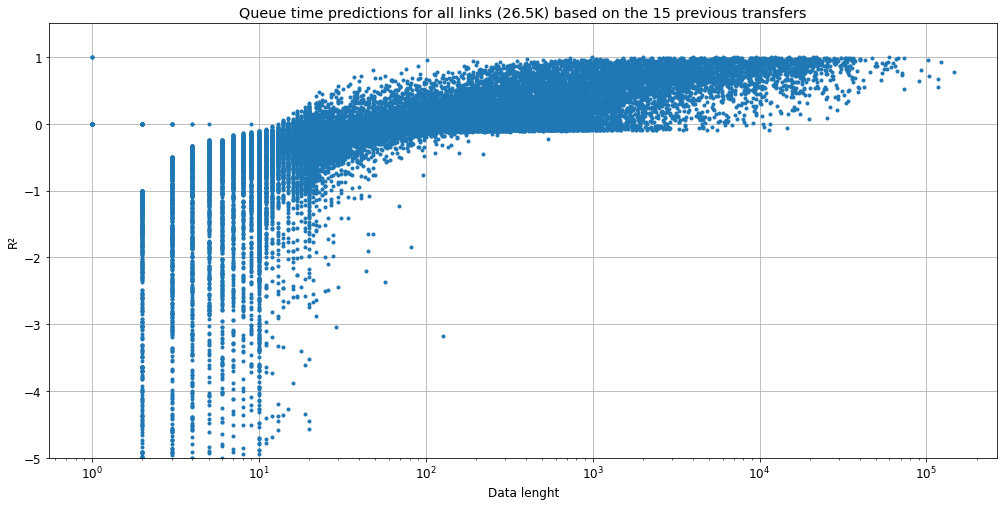

In [56]:
plt.plot(links_stats[:,3],links_stats[:,1],'.')
plt.xlabel('Data lenght')
plt.ylabel('R²')
plt.ylim((-5,1.5))
#plt.xlim((-1, 10000))
plt.xscale('log')
#plt.yscale('log')
plt.title('Queue time predictions for all links (26.5K) based on the 15 previous transfers')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

/home/ivukotic/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


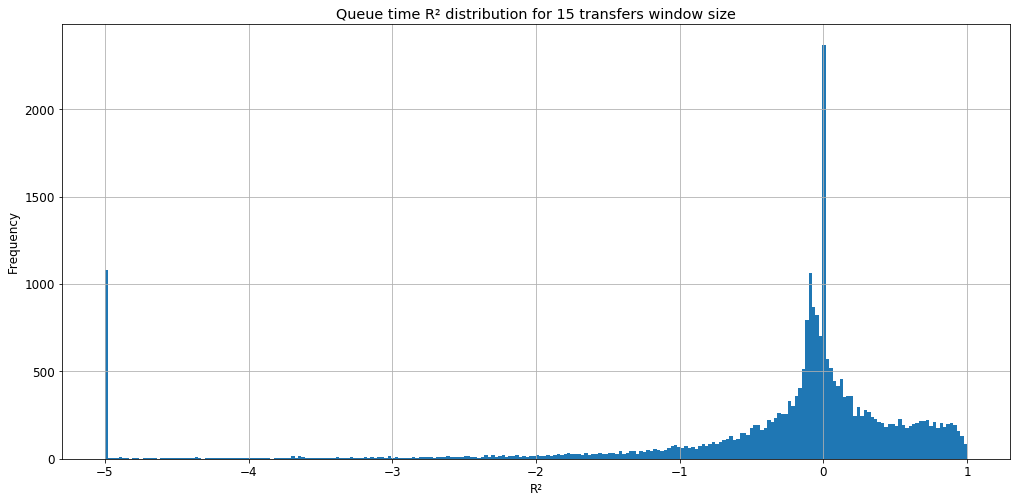

In [60]:
rscores = links_stats[:,1].astype('float')
rscores[rscores < -5] = -5
plt.hist(rscores, bins=250)
plt.title('Queue time R² distribution for 15 transfers window size')
#plt.ylim(-10,10)
plt.ylabel('Frequency')
plt.xlabel('R²')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

/home/ivukotic/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


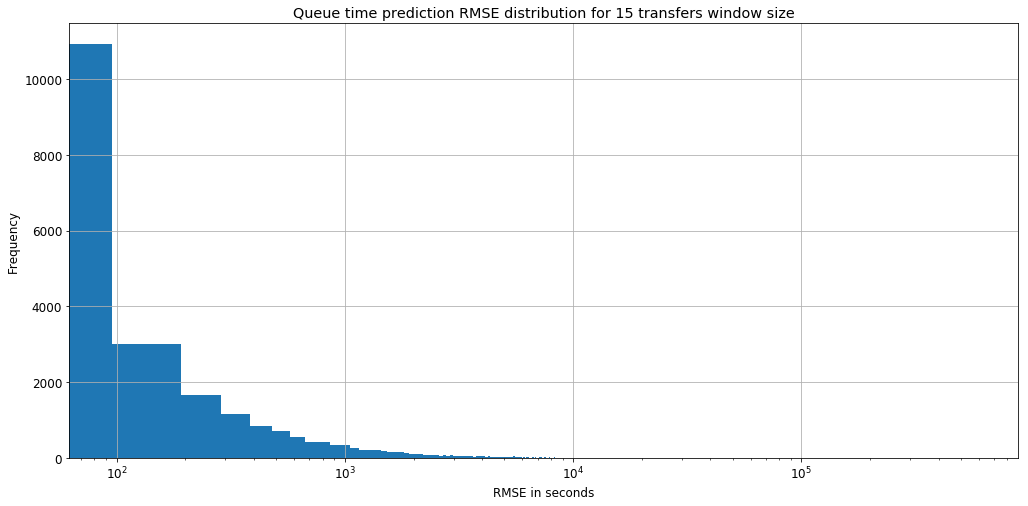

In [69]:
rscores = links_stats[:,2].astype('float')
#rscores[rscores < -500] = -500
plt.hist(rscores, bins=6000)
plt.title('Queue time prediction RMSE distribution for 15 transfers window size')
#plt.ylim(-10,10)
plt.xscale('log')
plt.ylabel('Frequency')
plt.xlabel('RMSE in seconds')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

/home/ivukotic/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


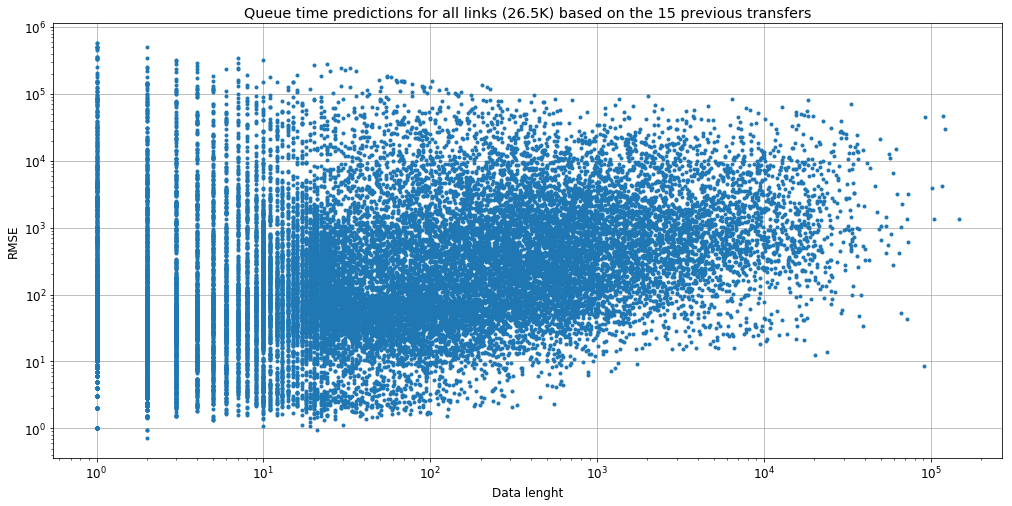

In [75]:
plt.plot(links_stats[:,3],links_stats[:,2],'.')
plt.xlabel('Data lenght')
plt.ylabel('RMSE')
#plt.ylim((-5,1.5))
#plt.xlim((-1, 10000))
plt.xscale('log')
plt.yscale('log')
plt.title('Queue time predictions for all links (26.5K) based on the 15 previous transfers')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()